# Bank Customer Transaction & Risk Analysis
### Retail Banking – Operations & Risk Analytics

## 1. Data Loading & Initial Inspection

In [1]:
import pandas as pd

df = pd.read_csv("data/paysim dataset.csv")

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df.shape

(6362620, 11)

## 2. Dataset Structure & Data Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## 3. Transaction Type Distribution
Understanding the volume of each transaction type.

In [4]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

### Key Observation
CASH_OUT and PAYMENT transactions dominate the dataset, indicating high outbound fund movement activity.
These transaction types will be evaluated later for risk behavior analysis.

## 4. Setting Up SQL Environment (SQLite Database)
Creating a local banking database to simulate production environment.

In [5]:
import sqlite3

# Create / connect to SQLite database file
conn = sqlite3.connect("banking.db")

print("SQLite database created successfully.")

SQLite database created successfully.


## 5. Creating Transactions Table
Selecting relevant columns for transaction-level analysis.

In [6]:
# Select relevant columns
transactions_df = df[['step', 'type', 'amount', 
                      'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
                      'nameDest', 'oldbalanceDest', 'newbalanceDest']].copy()

transactions_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


## 6. Renaming Columns for Business Clarity
Standardizing column names to reflect banking terminology.

In [7]:
transactions_df.rename(columns={
    'step': 'transaction_step',
    'type': 'transaction_type',
    'nameOrig': 'sender_id',
    'nameDest': 'receiver_id',
    'oldbalanceOrg': 'sender_old_balance',
    'newbalanceOrig': 'sender_new_balance',
    'oldbalanceDest': 'receiver_old_balance',
    'newbalanceDest': 'receiver_new_balance'
}, inplace=True)

transactions_df.head()

,transaction_step,transaction_type,amount,sender_id,sender_old_balance,sender_new_balance,receiver_id,receiver_old_balance,receiver_new_balance
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0


## 7. Loading Transactions into SQL Database
Writing transaction data into SQLite database.

In [8]:
# Load dataframe into SQLite
transactions_df.to_sql(
    name='transactions',
    con=conn,
    if_exists='replace',
    index=False
)

print("Transactions table created successfully in SQLite.")

Transactions table created successfully in SQLite.


## 8. Verifying Transactions Table in SQL
Confirming successful data load.

In [9]:
# Check row count from SQL
query = "SELECT COUNT(*) FROM transactions;"
pd.read_sql(query, conn)

,COUNT(*)
0,6362620


## 9. Weekly Transaction Volume
Analyzing transaction count per simulated week of the month.

In [10]:
query = """
SELECT 
    (transaction_step / 168) + 1 AS week,
    COUNT(*) AS total_transactions
FROM transactions
GROUP BY week
ORDER BY week;
"""

weekly_volume = pd.read_sql(query, conn)
weekly_volume

,week,total_transactions
0,1,1926356
1,2,2855487
2,3,1282183
3,4,231992
4,5,66602


## 10. Customer Transaction Frequency Assessment
Evaluating how many transactions each customer performs.

In [11]:
query = """
SELECT 
    COUNT(*) AS number_of_customers,
    MAX(txn_count) AS max_transactions_by_single_customer
FROM (
    SELECT sender_id, COUNT(*) AS txn_count
    FROM transactions
    GROUP BY sender_id
)
"""
pd.read_sql(query, conn)

,number_of_customers,max_transactions_by_single_customer
0,6353307,3


### Observation

Most customers in this dataset perform only 1 - 3 transactions. Because of this, calculating average transaction value per customer does not reveal meaningful behavioral patterns.

Since repeat activity is limited, frequency-based risk scoring is not very informative here. As a result, the analysis will focus more on transaction size, balance changes, and transaction type patterns to identify potential risk signals.

## 11. Large Balance Drop Analysis
Identifying transactions with significant reduction in sender balance.

In [12]:
query = """
SELECT 
    transaction_type,
    COUNT(*) AS txn_count,
    ROUND(AVG(sender_old_balance - sender_new_balance), 2) AS avg_balance_drop,
    ROUND(MAX(sender_old_balance - sender_new_balance), 2) AS max_balance_drop
FROM transactions
GROUP BY transaction_type
ORDER BY avg_balance_drop DESC;
"""

balance_drop_analysis = pd.read_sql(query, conn)
balance_drop_analysis

,transaction_type,txn_count,avg_balance_drop,max_balance_drop
0,TRANSFER,532909,44153.70,10000000.00
1,CASH_OUT,2237500,28549.61,10000000.00
2,PAYMENT,2151495,6378.94,185122.54
3,DEBIT,41432,3485.69,408672.21
4,CASH_IN,1399284,-168915.20,0.00


## 12. High-Risk Transaction Screening
Identifying high-value transfers and cash-out transactions.

In [13]:
query = """
SELECT 
    COUNT(*) AS high_risk_transactions,
    ROUND(AVG(amount), 2) AS avg_high_risk_amount
FROM transactions
WHERE amount > 1000000
AND transaction_type IN ('TRANSFER', 'CASH_OUT');
"""

pd.read_sql(query, conn)

,high_risk_transactions,avg_high_risk_amount
0,130507,2556332.29


## 13. Rule-Based Risk Tagging
Assigning risk levels using business logic.

In [14]:
query = """
SELECT 
    CASE
        WHEN amount > 1000000 
             AND transaction_type IN ('TRANSFER', 'CASH_OUT')
            THEN 'High Risk'
        WHEN amount > 1000000 
             OR transaction_type IN ('TRANSFER', 'CASH_OUT')
            THEN 'Medium Risk'
        ELSE 'Low Risk'
    END AS risk_category,
    COUNT(*) AS transaction_count
FROM transactions
GROUP BY risk_category;
"""

risk_distribution = pd.read_sql(query, conn)
risk_distribution

,risk_category,transaction_count
0,High Risk,130507
1,Low Risk,3592092
2,Medium Risk,2640021


In [15]:
risk_distribution['percentage'] = (
    risk_distribution['transaction_count'] / 
    risk_distribution['transaction_count'].sum()
) * 100

risk_distribution

,risk_category,transaction_count,percentage
0,High Risk,130507,2.051152
1,Low Risk,3592092,56.456177
2,Medium Risk,2640021,41.492671


### Risk Category Distribution
Visual representation of rule-based risk segmentation.

In [16]:
risk_order = ['Low Risk', 'Medium Risk', 'High Risk']
risk_distribution['risk_category'] = pd.Categorical(
    risk_distribution['risk_category'],
    categories=risk_order,
    ordered=True
)

risk_distribution = risk_distribution.sort_values('risk_category')

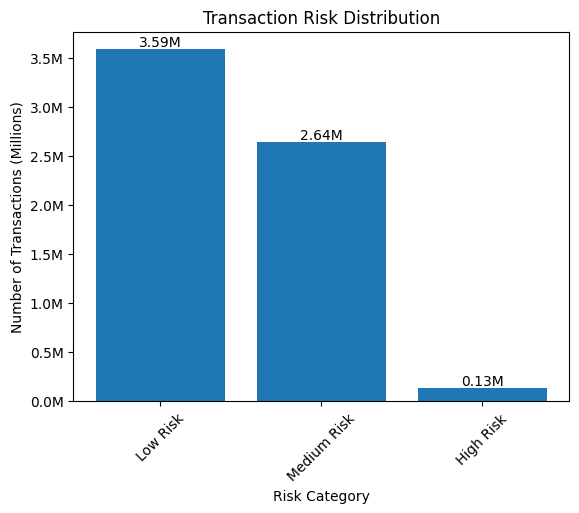

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()

bars = plt.bar(
    risk_distribution['risk_category'],
    risk_distribution['transaction_count']
)

plt.title("Transaction Risk Distribution")
plt.xlabel("Risk Category")
plt.ylabel("Number of Transactions (Millions)")
plt.xticks(rotation=45)

# Format y-axis in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
)

# Add data labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height/1_000_000:.2f}M',
        ha='center',
        va='bottom'
    )

plt.show()

## 14. Balance Drop Intensity Analysis
Measuring percentage reduction in sender balance per transaction.

In [18]:
query = """
SELECT 
    ROUND(AVG(
        CASE 
            WHEN sender_old_balance > 0 
                 AND transaction_type IN ('TRANSFER', 'CASH_OUT', 'PAYMENT', 'DEBIT')
            THEN (sender_old_balance - sender_new_balance) / sender_old_balance
        END
    ), 4) AS avg_balance_drop_pct
FROM transactions;
"""

pd.read_sql(query, conn)

,avg_balance_drop_pct
0,0.6535


## 15. Enhanced Risk Tagging with Balance Drop Intensity
Incorporating balance depletion behavior into risk classification.

In [19]:
query = """
SELECT 
    CASE
        WHEN amount > 1000000
             AND transaction_type IN ('TRANSFER', 'CASH_OUT')
             AND sender_old_balance > 0
             AND (sender_old_balance - sender_new_balance) / sender_old_balance > 0.8
            THEN 'High Risk'

        WHEN amount > 1000000
             OR transaction_type IN ('TRANSFER', 'CASH_OUT')
            THEN 'Medium Risk'

        ELSE 'Low Risk'
    END AS enhanced_risk_category,
    COUNT(*) AS transaction_count
FROM transactions
GROUP BY enhanced_risk_category;
"""

enhanced_risk_distribution = pd.read_sql(query, conn)
enhanced_risk_distribution

,enhanced_risk_category,transaction_count
0,High Risk,65542
1,Low Risk,3592092
2,Medium Risk,2704986


### Observation

After adding the balance depletion condition (greater than 80% reduction in account balance), the number of transactions classified as High Risk dropped from 130,507 to 65,542.

This shows that many large transactions were not necessarily draining accounts aggressively. By including balance intensity, the risk classification becomes more focused on genuinely disruptive transactions rather than simply high-value ones.

Overall, the refined rule produces a tighter and more behavior-driven High

### Enhanced Risk Distribution (With Balance Drop Condition)

In [20]:
risk_order = ['Low Risk', 'Medium Risk', 'High Risk']

enhanced_risk_distribution['enhanced_risk_category'] = pd.Categorical(
    enhanced_risk_distribution['enhanced_risk_category'],
    categories=risk_order,
    ordered=True
)

enhanced_risk_distribution = enhanced_risk_distribution.sort_values(
    'enhanced_risk_category'
)

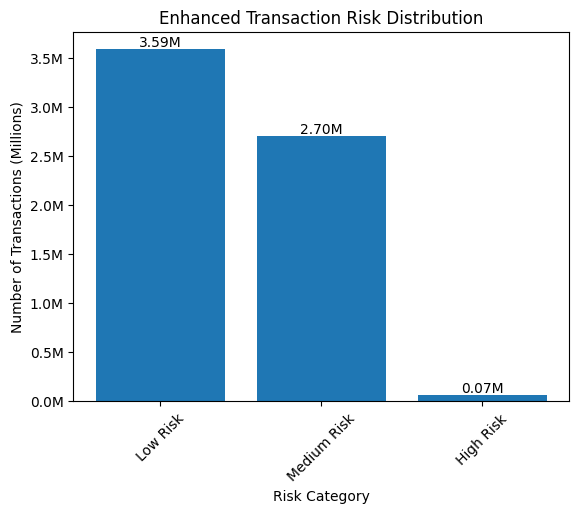

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()

bars = plt.bar(
    enhanced_risk_distribution['enhanced_risk_category'],
    enhanced_risk_distribution['transaction_count']
)

plt.title("Enhanced Transaction Risk Distribution")
plt.xlabel("Risk Category")
plt.ylabel("Number of Transactions (Millions)")
plt.xticks(rotation=45)

# Format y-axis in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1_000_000:.1f}M')
)

# Add data labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height/1_000_000:.2f}M',
        ha='center',
        va='bottom'
    )

plt.show()

## 16. High-Risk Exposure by Customer
Identifying customers contributing most to high-risk transaction volume.

In [22]:
query = """
WITH enhanced_risk AS (
    SELECT 
        sender_id,
        amount,
        CASE
            WHEN amount > 1000000
                 AND transaction_type IN ('TRANSFER', 'CASH_OUT')
                 AND sender_old_balance > 0
                 AND (sender_old_balance - sender_new_balance) / sender_old_balance > 0.8
                THEN 'High Risk'
            ELSE 'Other'
        END AS risk_flag
    FROM transactions
)

SELECT 
    sender_id,
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN risk_flag = 'High Risk' THEN 1 ELSE 0 END) AS high_risk_txn_count,
    ROUND(SUM(CASE WHEN risk_flag = 'High Risk' THEN amount ELSE 0 END), 2) AS total_high_risk_amount
FROM enhanced_risk
GROUP BY sender_id
HAVING high_risk_txn_count > 0
ORDER BY total_high_risk_amount DESC
LIMIT 10;
"""

top_high_risk_customers = pd.read_sql(query, conn)
top_high_risk_customers

,sender_id,total_transactions,high_risk_txn_count,total_high_risk_amount
0,C208486812,1,1,57787800.93
1,C1483754162,1,1,51141938.17
2,C539714486,1,1,47504216.38
3,C240100497,1,1,45372634.63
4,C1835360608,1,1,42183808.56
5,C2080983471,1,1,38919599.87
6,C1741076564,2,1,38874009.46
7,C2078977034,1,1,38448653.52
8,C2133858182,1,1,37663153.97
9,C102829469,1,1,37387628.10


### Observation

The high-risk exposure appears to be driven mostly by one-time large transactions rather than repeated risky behavior.

Almost all of the top customers flagged for high-risk activity performed only a single transaction, suggesting that risk in this dataset is event-based rather than frequency-based.

This indicates that monitoring systems in this context should prioritize detecting unusually large balance-depleting transactions, even if the customer has no prior history of suspicious activity.